In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/archive(3).zip"  # Change this
extract_path = "/content/drive/MyDrive/Colab Notebooks"   # Change this

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipping complete!")

✅ Unzipping complete!


In [ ]:
# Import the necessary library
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18

In [ ]:
# Define the original directories and their corresponding class names
original_dirs = {
    'Calculus': '/content/drive/MyDrive/Colab Notebooks/Calculus/Calculus',
    'Caries': '/content/drive/MyDrive/Colab Notebooks/Data caries/Data caries/caries augmented data set/preview',
    'Gingivitis': '/content/drive/MyDrive/Colab Notebooks/Gingivitis/Gingivitis',
    'Ulcers': '/content/drive/MyDrive/Colab Notebooks/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview',
    'Tooth Discoloration': '/content/drive/MyDrive/Colab Notebooks/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview',
    'Hypodontia': '/content/drive/MyDrive/Colab Notebooks/hypodontia/hypodontia'
}

# Define the target base directory
base_dir = '/content/drive/MyDrive/Colab Notebooks'

# Define the target structure
splits = ['train', 'val', 'test']
classes = list(original_dirs.keys())

# Create target directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

# Function to copy images to the target directory and count them
def copy_and_count_images(class_name, image_paths):
    # Split the data
    train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)  # 0.2 * 0.9 = 0.18

    # Define split mappings
    split_paths = {
        'train': train_paths,
        'val': val_paths,
        'test': test_paths
    }

    # Copy images to their respective directories and count them
    for split, paths in split_paths.items():
        class_split_counts[class_name][split] = len(paths)
        for img_path in paths:
            target_path = os.path.join(base_dir, split, class_name, os.path.basename(img_path))
            shutil.copy(img_path, target_path)

# Traverse the original directories and gather image paths
for class_name, original_dir in original_dirs.items():
    image_paths = []
    for root, dirs, files in os.walk(original_dir):
        image_paths.extend([os.path.join(root, file) for file in files if file.endswith(('.jpg', '.jpeg', '.png'))])
    if image_paths:
        copy_and_count_images(class_name, image_paths)

print("Images have been copied and organized successfully.")

Images have been copied and organized successfully.


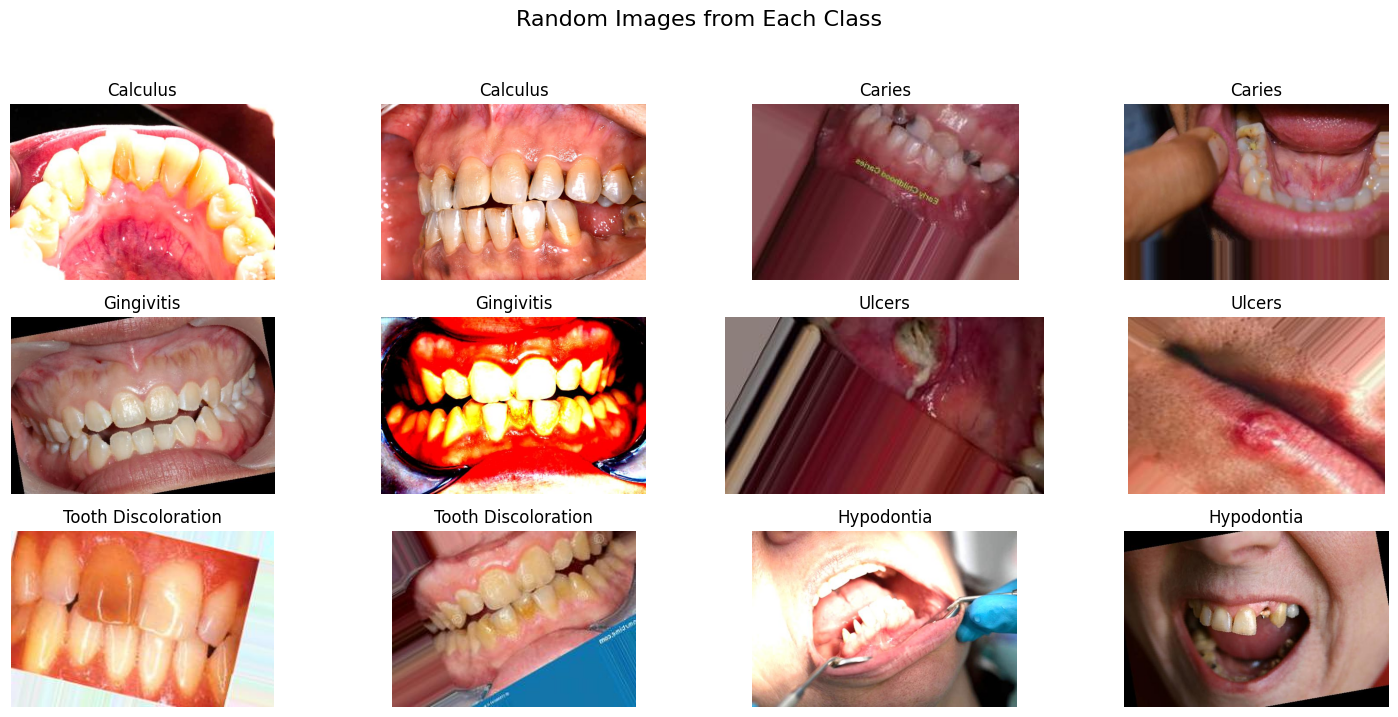

In [ ]:
# Number of images to display per class and per row
num_images_per_class = 2
num_images_per_row = 4

# Set seed for reproducibility
random.seed(42)

# Function to get random images from a directory
def get_random_images_from_dir(directory, num_images):
    all_images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.jpg', '.jpeg', '.png'))]
    if len(all_images) < num_images:
        return all_images
    return random.sample(all_images, num_images)

# Create a figure
num_rows = (len(classes) * num_images_per_class + num_images_per_row - 1) // num_images_per_row  # Calculate number of rows needed
fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 2.5))
fig.suptitle('Random Images from Each Class', fontsize=16)

# Flatten axs array for easier indexing
axs = axs.flatten()

# Iterate through classes and display images
image_idx = 0
for class_name in classes:
    class_dir = os.path.join(base_dir, 'train', class_name)
    random_images = get_random_images_from_dir(class_dir, num_images_per_class)

    for img_path in random_images:
        if image_idx < len(axs):
            img = Image.open(img_path)
            ax = axs[image_idx]
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')
            image_idx += 1

# Hide any unused subplots
for i in range(image_idx, len(axs)):
    axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

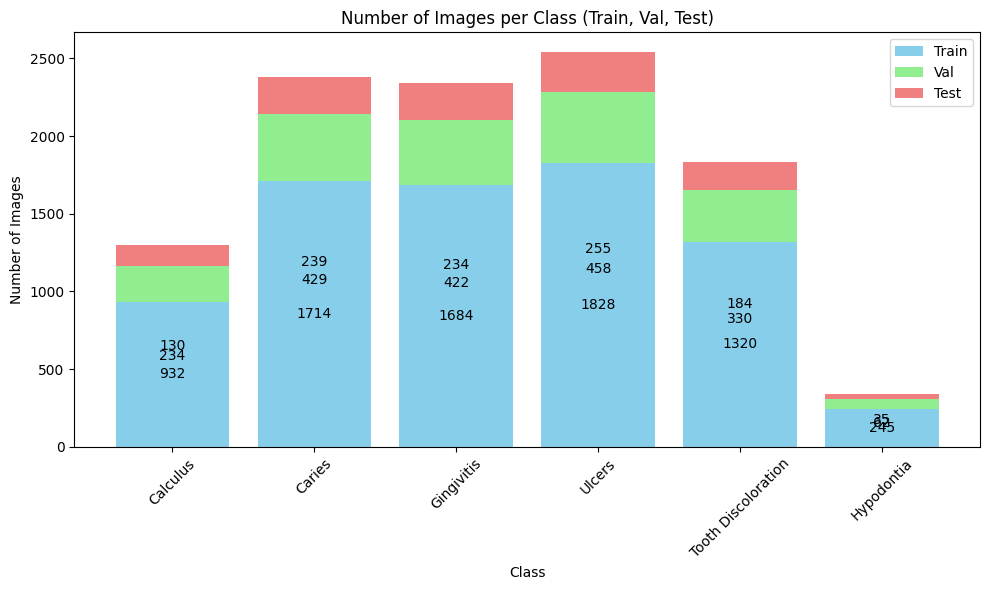

In [ ]:
# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

# Function to count images in each split
def count_images(base_dir, class_name):
    counts = {}
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split, class_name)
        counts[split] = len(os.listdir(split_dir))
    return counts

# Calculate counts for each class and split
for class_name in classes:
    class_split_counts[class_name] = count_images(base_dir, class_name)

# Create lists for the bar plot
labels = classes
train_counts = [class_split_counts[class_name]['train'] for class_name in classes]
val_counts = [class_split_counts[class_name]['val'] for class_name in classes]
test_counts = [class_split_counts[class_name]['test'] for class_name in classes]

x = range(len(classes))

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x, train_counts, label='Train', color='skyblue')
bar2 = ax.bar(x, val_counts, bottom=train_counts, label='Val', color='lightgreen')
bar3 = ax.bar(x, test_counts, bottom=[i+j for i,j in zip(train_counts, val_counts)], label='Test', color='lightcoral')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (Train, Val, Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Add data labels
for bar in bar1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(yval), ha='center', va='center', color='black')

for bar in bar2:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(bar.get_height()), ha='center', va='center', color='black')

for bar in bar3:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(bar.get_height()), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Define directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
image_size = (128, 128)
batch_size = 16
num_epochs = 10

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Normalization for validation and testing
val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_transforms)
test_dataset = ImageFolder(test_dir, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121

# Get number of classes
num_classes = len(train_dataset.classes)

# Use a smaller model - DenseNet121
class CustomDenseNet(nn.Module):
    def __init__(self):
        super(CustomDenseNet, self).__init__()
        self.model = densenet121(weights=True)  # Load pre-trained DenseNet121
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = CustomDenseNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 95.3MB/s]


In [ ]:
# Set environment variable to avoid threading issues
os.environ["OMP_NUM_THREADS"] = "1"

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping parameters
early_stopping = True
patience = 3  # Number of epochs to wait if no improvement is observed

# Initialize early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Initialize lists to store losses, accuracies, and learning rates
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Variables to store y_true and y_scores for precision-recall calculation
y_true = []
y_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []
    val_outputs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            val_outputs.extend(outputs.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = accuracy_score(val_true, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Append true labels and predicted scores for precision-recall calculation
    y_true.extend(val_true)
    y_scores.extend(val_outputs)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model checkpoint here if you want

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            early_stop = True
            break

    # LR scheduler step based on validation loss
    scheduler.step(val_loss)

    if early_stop:
        break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Train Loss: 0.8630, Val Loss: 0.6072, Val Acc: 0.7401


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/10], Train Loss: 0.5993, Val Loss: 0.5808, Val Acc: 0.7695


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/10], Train Loss: 0.5143, Val Loss: 0.5299, Val Acc: 0.7907


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/10], Train Loss: 0.4301, Val Loss: 0.3831, Val Acc: 0.8196


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/10], Train Loss: 0.4199, Val Loss: 0.3932, Val Acc: 0.8357


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/10], Train Loss: 0.3515, Val Loss: 0.4006, Val Acc: 0.8460


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [7/10], Train Loss: 0.3257, Val Loss: 0.3512, Val Acc: 0.8512


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [8/10], Train Loss: 0.3072, Val Loss: 0.2707, Val Acc: 0.8842


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [9/10], Train Loss: 0.3075, Val Loss: 0.4345, Val Acc: 0.8088


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [10/10], Train Loss: 0.2772, Val Loss: 0.2982, Val Acc: 0.8765


In [ ]:
# Save only the model weights
torch.save(model.state_dict(), "best_model.pth")

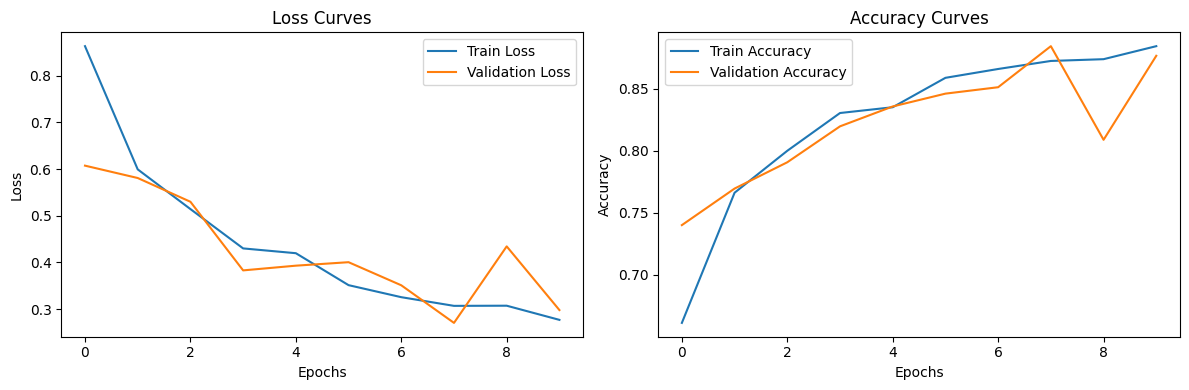

In [ ]:
# Plotting loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the correct model architecture
model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features

# Define class labels (Ensure these match the classes used during training)
class_names = ['Calculus', 'Caries', 'Gingivitis', 'Ulcers', 'Tooth Discoloration', 'Hypodontia']
model.classifier = nn.Linear(num_ftrs, len(class_names))  # Adjust classifier for correct output classes

# Load the trained model weights
model_path = "/content/best_model.pth"
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint)
model.eval()  # Set model to evaluation mode

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load and preprocess the image
image_path = "/content/drive/MyDrive/Colab Notebooks/Calculus/Calculus/(1).jpg"  # Change this to the path of the image
image = Image.open(image_path).convert("RGB")  # Ensure it's RGB
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class = torch.argmax(probabilities).item()

# Display the image and prediction
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {class_names[predicted_class]}\nConfidence: {probabilities[predicted_class]:.2f}")
plt.show()


<ipython-input-22-ecd676479991>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cpu")


RuntimeError: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "features.conv0.weight", "features.norm0.weight", "features.norm0.bias", "features.norm0.running_mean", "features.norm0.running_var", "features.denseblock1.denselayer1.norm1.weight", "features.denseblock1.denselayer1.norm1.bias", "features.denseblock1.denselayer1.norm1.running_mean", "features.denseblock1.denselayer1.norm1.running_var", "features.denseblock1.denselayer1.conv1.weight", "features.denseblock1.denselayer1.norm2.weight", "features.denseblock1.denselayer1.norm2.bias", "features.denseblock1.denselayer1.norm2.running_mean", "features.denseblock1.denselayer1.norm2.running_var", "features.denseblock1.denselayer1.conv2.weight", "features.denseblock1.denselayer2.norm1.weight", "features.denseblock1.denselayer2.norm1.bias", "features.denseblock1.denselayer2.norm1.running_mean", "features.denseblock1.denselayer2.norm1.running_var", "features.denseblock1.denselayer2.conv1.weight", "features.denseblock1.denselayer2.norm2.weight", "features.denseblock1.denselayer2.norm2.bias", "features.denseblock1.denselayer2.norm2.running_mean", "features.denseblock1.denselayer2.norm2.running_var", "features.denseblock1.denselayer2.conv2.weight", "features.denseblock1.denselayer3.norm1.weight", "features.denseblock1.denselayer3.norm1.bias", "features.denseblock1.denselayer3.norm1.running_mean", "features.denseblock1.denselayer3.norm1.running_var", "features.denseblock1.denselayer3.conv1.weight", "features.denseblock1.denselayer3.norm2.weight", "features.denseblock1.denselayer3.norm2.bias", "features.denseblock1.denselayer3.norm2.running_mean", "features.denseblock1.denselayer3.norm2.running_var", "features.denseblock1.denselayer3.conv2.weight", "features.denseblock1.denselayer4.norm1.weight", "features.denseblock1.denselayer4.norm1.bias", "features.denseblock1.denselayer4.norm1.running_mean", "features.denseblock1.denselayer4.norm1.running_var", "features.denseblock1.denselayer4.conv1.weight", "features.denseblock1.denselayer4.norm2.weight", "features.denseblock1.denselayer4.norm2.bias", "features.denseblock1.denselayer4.norm2.running_mean", "features.denseblock1.denselayer4.norm2.running_var", "features.denseblock1.denselayer4.conv2.weight", "features.denseblock1.denselayer5.norm1.weight", "features.denseblock1.denselayer5.norm1.bias", "features.denseblock1.denselayer5.norm1.running_mean", "features.denseblock1.denselayer5.norm1.running_var", "features.denseblock1.denselayer5.conv1.weight", "features.denseblock1.denselayer5.norm2.weight", "features.denseblock1.denselayer5.norm2.bias", "features.denseblock1.denselayer5.norm2.running_mean", "features.denseblock1.denselayer5.norm2.running_var", "features.denseblock1.denselayer5.conv2.weight", "features.denseblock1.denselayer6.norm1.weight", "features.denseblock1.denselayer6.norm1.bias", "features.denseblock1.denselayer6.norm1.running_mean", "features.denseblock1.denselayer6.norm1.running_var", "features.denseblock1.denselayer6.conv1.weight", "features.denseblock1.denselayer6.norm2.weight", "features.denseblock1.denselayer6.norm2.bias", "features.denseblock1.denselayer6.norm2.running_mean", "features.denseblock1.denselayer6.norm2.running_var", "features.denseblock1.denselayer6.conv2.weight", "features.transition1.norm.weight", "features.transition1.norm.bias", "features.transition1.norm.running_mean", "features.transition1.norm.running_var", "features.transition1.conv.weight", "features.denseblock2.denselayer1.norm1.weight", "features.denseblock2.denselayer1.norm1.bias", "features.denseblock2.denselayer1.norm1.running_mean", "features.denseblock2.denselayer1.norm1.running_var", "features.denseblock2.denselayer1.conv1.weight", "features.denseblock2.denselayer1.norm2.weight", "features.denseblock2.denselayer1.norm2.bias", "features.denseblock2.denselayer1.norm2.running_mean", "features.denseblock2.denselayer1.norm2.running_var", "features.denseblock2.denselayer1.conv2.weight", "features.denseblock2.denselayer2.norm1.weight", "features.denseblock2.denselayer2.norm1.bias", "features.denseblock2.denselayer2.norm1.running_mean", "features.denseblock2.denselayer2.norm1.running_var", "features.denseblock2.denselayer2.conv1.weight", "features.denseblock2.denselayer2.norm2.weight", "features.denseblock2.denselayer2.norm2.bias", "features.denseblock2.denselayer2.norm2.running_mean", "features.denseblock2.denselayer2.norm2.running_var", "features.denseblock2.denselayer2.conv2.weight", "features.denseblock2.denselayer3.norm1.weight", "features.denseblock2.denselayer3.norm1.bias", "features.denseblock2.denselayer3.norm1.running_mean", "features.denseblock2.denselayer3.norm1.running_var", "features.denseblock2.denselayer3.conv1.weight", "features.denseblock2.denselayer3.norm2.weight", "features.denseblock2.denselayer3.norm2.bias", "features.denseblock2.denselayer3.norm2.running_mean", "features.denseblock2.denselayer3.norm2.running_var", "features.denseblock2.denselayer3.conv2.weight", "features.denseblock2.denselayer4.norm1.weight", "features.denseblock2.denselayer4.norm1.bias", "features.denseblock2.denselayer4.norm1.running_mean", "features.denseblock2.denselayer4.norm1.running_var", "features.denseblock2.denselayer4.conv1.weight", "features.denseblock2.denselayer4.norm2.weight", "features.denseblock2.denselayer4.norm2.bias", "features.denseblock2.denselayer4.norm2.running_mean", "features.denseblock2.denselayer4.norm2.running_var", "features.denseblock2.denselayer4.conv2.weight", "features.denseblock2.denselayer5.norm1.weight", "features.denseblock2.denselayer5.norm1.bias", "features.denseblock2.denselayer5.norm1.running_mean", "features.denseblock2.denselayer5.norm1.running_var", "features.denseblock2.denselayer5.conv1.weight", "features.denseblock2.denselayer5.norm2.weight", "features.denseblock2.denselayer5.norm2.bias", "features.denseblock2.denselayer5.norm2.running_mean", "features.denseblock2.denselayer5.norm2.running_var", "features.denseblock2.denselayer5.conv2.weight", "features.denseblock2.denselayer6.norm1.weight", "features.denseblock2.denselayer6.norm1.bias", "features.denseblock2.denselayer6.norm1.running_mean", "features.denseblock2.denselayer6.norm1.running_var", "features.denseblock2.denselayer6.conv1.weight", "features.denseblock2.denselayer6.norm2.weight", "features.denseblock2.denselayer6.norm2.bias", "features.denseblock2.denselayer6.norm2.running_mean", "features.denseblock2.denselayer6.norm2.running_var", "features.denseblock2.denselayer6.conv2.weight", "features.denseblock2.denselayer7.norm1.weight", "features.denseblock2.denselayer7.norm1.bias", "features.denseblock2.denselayer7.norm1.running_mean", "features.denseblock2.denselayer7.norm1.running_var", "features.denseblock2.denselayer7.conv1.weight", "features.denseblock2.denselayer7.norm2.weight", "features.denseblock2.denselayer7.norm2.bias", "features.denseblock2.denselayer7.norm2.running_mean", "features.denseblock2.denselayer7.norm2.running_var", "features.denseblock2.denselayer7.conv2.weight", "features.denseblock2.denselayer8.norm1.weight", "features.denseblock2.denselayer8.norm1.bias", "features.denseblock2.denselayer8.norm1.running_mean", "features.denseblock2.denselayer8.norm1.running_var", "features.denseblock2.denselayer8.conv1.weight", "features.denseblock2.denselayer8.norm2.weight", "features.denseblock2.denselayer8.norm2.bias", "features.denseblock2.denselayer8.norm2.running_mean", "features.denseblock2.denselayer8.norm2.running_var", "features.denseblock2.denselayer8.conv2.weight", "features.denseblock2.denselayer9.norm1.weight", "features.denseblock2.denselayer9.norm1.bias", "features.denseblock2.denselayer9.norm1.running_mean", "features.denseblock2.denselayer9.norm1.running_var", "features.denseblock2.denselayer9.conv1.weight", "features.denseblock2.denselayer9.norm2.weight", "features.denseblock2.denselayer9.norm2.bias", "features.denseblock2.denselayer9.norm2.running_mean", "features.denseblock2.denselayer9.norm2.running_var", "features.denseblock2.denselayer9.conv2.weight", "features.denseblock2.denselayer10.norm1.weight", "features.denseblock2.denselayer10.norm1.bias", "features.denseblock2.denselayer10.norm1.running_mean", "features.denseblock2.denselayer10.norm1.running_var", "features.denseblock2.denselayer10.conv1.weight", "features.denseblock2.denselayer10.norm2.weight", "features.denseblock2.denselayer10.norm2.bias", "features.denseblock2.denselayer10.norm2.running_mean", "features.denseblock2.denselayer10.norm2.running_var", "features.denseblock2.denselayer10.conv2.weight", "features.denseblock2.denselayer11.norm1.weight", "features.denseblock2.denselayer11.norm1.bias", "features.denseblock2.denselayer11.norm1.running_mean", "features.denseblock2.denselayer11.norm1.running_var", "features.denseblock2.denselayer11.conv1.weight", "features.denseblock2.denselayer11.norm2.weight", "features.denseblock2.denselayer11.norm2.bias", "features.denseblock2.denselayer11.norm2.running_mean", "features.denseblock2.denselayer11.norm2.running_var", "features.denseblock2.denselayer11.conv2.weight", "features.denseblock2.denselayer12.norm1.weight", "features.denseblock2.denselayer12.norm1.bias", "features.denseblock2.denselayer12.norm1.running_mean", "features.denseblock2.denselayer12.norm1.running_var", "features.denseblock2.denselayer12.conv1.weight", "features.denseblock2.denselayer12.norm2.weight", "features.denseblock2.denselayer12.norm2.bias", "features.denseblock2.denselayer12.norm2.running_mean", "features.denseblock2.denselayer12.norm2.running_var", "features.denseblock2.denselayer12.conv2.weight", "features.transition2.norm.weight", "features.transition2.norm.bias", "features.transition2.norm.running_mean", "features.transition2.norm.running_var", "features.transition2.conv.weight", "features.denseblock3.denselayer1.norm1.weight", "features.denseblock3.denselayer1.norm1.bias", "features.denseblock3.denselayer1.norm1.running_mean", "features.denseblock3.denselayer1.norm1.running_var", "features.denseblock3.denselayer1.conv1.weight", "features.denseblock3.denselayer1.norm2.weight", "features.denseblock3.denselayer1.norm2.bias", "features.denseblock3.denselayer1.norm2.running_mean", "features.denseblock3.denselayer1.norm2.running_var", "features.denseblock3.denselayer1.conv2.weight", "features.denseblock3.denselayer2.norm1.weight", "features.denseblock3.denselayer2.norm1.bias", "features.denseblock3.denselayer2.norm1.running_mean", "features.denseblock3.denselayer2.norm1.running_var", "features.denseblock3.denselayer2.conv1.weight", "features.denseblock3.denselayer2.norm2.weight", "features.denseblock3.denselayer2.norm2.bias", "features.denseblock3.denselayer2.norm2.running_mean", "features.denseblock3.denselayer2.norm2.running_var", "features.denseblock3.denselayer2.conv2.weight", "features.denseblock3.denselayer3.norm1.weight", "features.denseblock3.denselayer3.norm1.bias", "features.denseblock3.denselayer3.norm1.running_mean", "features.denseblock3.denselayer3.norm1.running_var", "features.denseblock3.denselayer3.conv1.weight", "features.denseblock3.denselayer3.norm2.weight", "features.denseblock3.denselayer3.norm2.bias", "features.denseblock3.denselayer3.norm2.running_mean", "features.denseblock3.denselayer3.norm2.running_var", "features.denseblock3.denselayer3.conv2.weight", "features.denseblock3.denselayer4.norm1.weight", "features.denseblock3.denselayer4.norm1.bias", "features.denseblock3.denselayer4.norm1.running_mean", "features.denseblock3.denselayer4.norm1.running_var", "features.denseblock3.denselayer4.conv1.weight", "features.denseblock3.denselayer4.norm2.weight", "features.denseblock3.denselayer4.norm2.bias", "features.denseblock3.denselayer4.norm2.running_mean", "features.denseblock3.denselayer4.norm2.running_var", "features.denseblock3.denselayer4.conv2.weight", "features.denseblock3.denselayer5.norm1.weight", "features.denseblock3.denselayer5.norm1.bias", "features.denseblock3.denselayer5.norm1.running_mean", "features.denseblock3.denselayer5.norm1.running_var", "features.denseblock3.denselayer5.conv1.weight", "features.denseblock3.denselayer5.norm2.weight", "features.denseblock3.denselayer5.norm2.bias", "features.denseblock3.denselayer5.norm2.running_mean", "features.denseblock3.denselayer5.norm2.running_var", "features.denseblock3.denselayer5.conv2.weight", "features.denseblock3.denselayer6.norm1.weight", "features.denseblock3.denselayer6.norm1.bias", "features.denseblock3.denselayer6.norm1.running_mean", "features.denseblock3.denselayer6.norm1.running_var", "features.denseblock3.denselayer6.conv1.weight", "features.denseblock3.denselayer6.norm2.weight", "features.denseblock3.denselayer6.norm2.bias", "features.denseblock3.denselayer6.norm2.running_mean", "features.denseblock3.denselayer6.norm2.running_var", "features.denseblock3.denselayer6.conv2.weight", "features.denseblock3.denselayer7.norm1.weight", "features.denseblock3.denselayer7.norm1.bias", "features.denseblock3.denselayer7.norm1.running_mean", "features.denseblock3.denselayer7.norm1.running_var", "features.denseblock3.denselayer7.conv1.weight", "features.denseblock3.denselayer7.norm2.weight", "features.denseblock3.denselayer7.norm2.bias", "features.denseblock3.denselayer7.norm2.running_mean", "features.denseblock3.denselayer7.norm2.running_var", "features.denseblock3.denselayer7.conv2.weight", "features.denseblock3.denselayer8.norm1.weight", "features.denseblock3.denselayer8.norm1.bias", "features.denseblock3.denselayer8.norm1.running_mean", "features.denseblock3.denselayer8.norm1.running_var", "features.denseblock3.denselayer8.conv1.weight", "features.denseblock3.denselayer8.norm2.weight", "features.denseblock3.denselayer8.norm2.bias", "features.denseblock3.denselayer8.norm2.running_mean", "features.denseblock3.denselayer8.norm2.running_var", "features.denseblock3.denselayer8.conv2.weight", "features.denseblock3.denselayer9.norm1.weight", "features.denseblock3.denselayer9.norm1.bias", "features.denseblock3.denselayer9.norm1.running_mean", "features.denseblock3.denselayer9.norm1.running_var", "features.denseblock3.denselayer9.conv1.weight", "features.denseblock3.denselayer9.norm2.weight", "features.denseblock3.denselayer9.norm2.bias", "features.denseblock3.denselayer9.norm2.running_mean", "features.denseblock3.denselayer9.norm2.running_var", "features.denseblock3.denselayer9.conv2.weight", "features.denseblock3.denselayer10.norm1.weight", "features.denseblock3.denselayer10.norm1.bias", "features.denseblock3.denselayer10.norm1.running_mean", "features.denseblock3.denselayer10.norm1.running_var", "features.denseblock3.denselayer10.conv1.weight", "features.denseblock3.denselayer10.norm2.weight", "features.denseblock3.denselayer10.norm2.bias", "features.denseblock3.denselayer10.norm2.running_mean", "features.denseblock3.denselayer10.norm2.running_var", "features.denseblock3.denselayer10.conv2.weight", "features.denseblock3.denselayer11.norm1.weight", "features.denseblock3.denselayer11.norm1.bias", "features.denseblock3.denselayer11.norm1.running_mean", "features.denseblock3.denselayer11.norm1.running_var", "features.denseblock3.denselayer11.conv1.weight", "features.denseblock3.denselayer11.norm2.weight", "features.denseblock3.denselayer11.norm2.bias", "features.denseblock3.denselayer11.norm2.running_mean", "features.denseblock3.denselayer11.norm2.running_var", "features.denseblock3.denselayer11.conv2.weight", "features.denseblock3.denselayer12.norm1.weight", "features.denseblock3.denselayer12.norm1.bias", "features.denseblock3.denselayer12.norm1.running_mean", "features.denseblock3.denselayer12.norm1.running_var", "features.denseblock3.denselayer12.conv1.weight", "features.denseblock3.denselayer12.norm2.weight", "features.denseblock3.denselayer12.norm2.bias", "features.denseblock3.denselayer12.norm2.running_mean", "features.denseblock3.denselayer12.norm2.running_var", "features.denseblock3.denselayer12.conv2.weight", "features.denseblock3.denselayer13.norm1.weight", "features.denseblock3.denselayer13.norm1.bias", "features.denseblock3.denselayer13.norm1.running_mean", "features.denseblock3.denselayer13.norm1.running_var", "features.denseblock3.denselayer13.conv1.weight", "features.denseblock3.denselayer13.norm2.weight", "features.denseblock3.denselayer13.norm2.bias", "features.denseblock3.denselayer13.norm2.running_mean", "features.denseblock3.denselayer13.norm2.running_var", "features.denseblock3.denselayer13.conv2.weight", "features.denseblock3.denselayer14.norm1.weight", "features.denseblock3.denselayer14.norm1.bias", "features.denseblock3.denselayer14.norm1.running_mean", "features.denseblock3.denselayer14.norm1.running_var", "features.denseblock3.denselayer14.conv1.weight", "features.denseblock3.denselayer14.norm2.weight", "features.denseblock3.denselayer14.norm2.bias", "features.denseblock3.denselayer14.norm2.running_mean", "features.denseblock3.denselayer14.norm2.running_var", "features.denseblock3.denselayer14.conv2.weight", "features.denseblock3.denselayer15.norm1.weight", "features.denseblock3.denselayer15.norm1.bias", "features.denseblock3.denselayer15.norm1.running_mean", "features.denseblock3.denselayer15.norm1.running_var", "features.denseblock3.denselayer15.conv1.weight", "features.denseblock3.denselayer15.norm2.weight", "features.denseblock3.denselayer15.norm2.bias", "features.denseblock3.denselayer15.norm2.running_mean", "features.denseblock3.denselayer15.norm2.running_var", "features.denseblock3.denselayer15.conv2.weight", "features.denseblock3.denselayer16.norm1.weight", "features.denseblock3.denselayer16.norm1.bias", "features.denseblock3.denselayer16.norm1.running_mean", "features.denseblock3.denselayer16.norm1.running_var", "features.denseblock3.denselayer16.conv1.weight", "features.denseblock3.denselayer16.norm2.weight", "features.denseblock3.denselayer16.norm2.bias", "features.denseblock3.denselayer16.norm2.running_mean", "features.denseblock3.denselayer16.norm2.running_var", "features.denseblock3.denselayer16.conv2.weight", "features.denseblock3.denselayer17.norm1.weight", "features.denseblock3.denselayer17.norm1.bias", "features.denseblock3.denselayer17.norm1.running_mean", "features.denseblock3.denselayer17.norm1.running_var", "features.denseblock3.denselayer17.conv1.weight", "features.denseblock3.denselayer17.norm2.weight", "features.denseblock3.denselayer17.norm2.bias", "features.denseblock3.denselayer17.norm2.running_mean", "features.denseblock3.denselayer17.norm2.running_var", "features.denseblock3.denselayer17.conv2.weight", "features.denseblock3.denselayer18.norm1.weight", "features.denseblock3.denselayer18.norm1.bias", "features.denseblock3.denselayer18.norm1.running_mean", "features.denseblock3.denselayer18.norm1.running_var", "features.denseblock3.denselayer18.conv1.weight", "features.denseblock3.denselayer18.norm2.weight", "features.denseblock3.denselayer18.norm2.bias", "features.denseblock3.denselayer18.norm2.running_mean", "features.denseblock3.denselayer18.norm2.running_var", "features.denseblock3.denselayer18.conv2.weight", "features.denseblock3.denselayer19.norm1.weight", "features.denseblock3.denselayer19.norm1.bias", "features.denseblock3.denselayer19.norm1.running_mean", "features.denseblock3.denselayer19.norm1.running_var", "features.denseblock3.denselayer19.conv1.weight", "features.denseblock3.denselayer19.norm2.weight", "features.denseblock3.denselayer19.norm2.bias", "features.denseblock3.denselayer19.norm2.running_mean", "features.denseblock3.denselayer19.norm2.running_var", "features.denseblock3.denselayer19.conv2.weight", "features.denseblock3.denselayer20.norm1.weight", "features.denseblock3.denselayer20.norm1.bias", "features.denseblock3.denselayer20.norm1.running_mean", "features.denseblock3.denselayer20.norm1.running_var", "features.denseblock3.denselayer20.conv1.weight", "features.denseblock3.denselayer20.norm2.weight", "features.denseblock3.denselayer20.norm2.bias", "features.denseblock3.denselayer20.norm2.running_mean", "features.denseblock3.denselayer20.norm2.running_var", "features.denseblock3.denselayer20.conv2.weight", "features.denseblock3.denselayer21.norm1.weight", "features.denseblock3.denselayer21.norm1.bias", "features.denseblock3.denselayer21.norm1.running_mean", "features.denseblock3.denselayer21.norm1.running_var", "features.denseblock3.denselayer21.conv1.weight", "features.denseblock3.denselayer21.norm2.weight", "features.denseblock3.denselayer21.norm2.bias", "features.denseblock3.denselayer21.norm2.running_mean", "features.denseblock3.denselayer21.norm2.running_var", "features.denseblock3.denselayer21.conv2.weight", "features.denseblock3.denselayer22.norm1.weight", "features.denseblock3.denselayer22.norm1.bias", "features.denseblock3.denselayer22.norm1.running_mean", "features.denseblock3.denselayer22.norm1.running_var", "features.denseblock3.denselayer22.conv1.weight", "features.denseblock3.denselayer22.norm2.weight", "features.denseblock3.denselayer22.norm2.bias", "features.denseblock3.denselayer22.norm2.running_mean", "features.denseblock3.denselayer22.norm2.running_var", "features.denseblock3.denselayer22.conv2.weight", "features.denseblock3.denselayer23.norm1.weight", "features.denseblock3.denselayer23.norm1.bias", "features.denseblock3.denselayer23.norm1.running_mean", "features.denseblock3.denselayer23.norm1.running_var", "features.denseblock3.denselayer23.conv1.weight", "features.denseblock3.denselayer23.norm2.weight", "features.denseblock3.denselayer23.norm2.bias", "features.denseblock3.denselayer23.norm2.running_mean", "features.denseblock3.denselayer23.norm2.running_var", "features.denseblock3.denselayer23.conv2.weight", "features.denseblock3.denselayer24.norm1.weight", "features.denseblock3.denselayer24.norm1.bias", "features.denseblock3.denselayer24.norm1.running_mean", "features.denseblock3.denselayer24.norm1.running_var", "features.denseblock3.denselayer24.conv1.weight", "features.denseblock3.denselayer24.norm2.weight", "features.denseblock3.denselayer24.norm2.bias", "features.denseblock3.denselayer24.norm2.running_mean", "features.denseblock3.denselayer24.norm2.running_var", "features.denseblock3.denselayer24.conv2.weight", "features.transition3.norm.weight", "features.transition3.norm.bias", "features.transition3.norm.running_mean", "features.transition3.norm.running_var", "features.transition3.conv.weight", "features.denseblock4.denselayer1.norm1.weight", "features.denseblock4.denselayer1.norm1.bias", "features.denseblock4.denselayer1.norm1.running_mean", "features.denseblock4.denselayer1.norm1.running_var", "features.denseblock4.denselayer1.conv1.weight", "features.denseblock4.denselayer1.norm2.weight", "features.denseblock4.denselayer1.norm2.bias", "features.denseblock4.denselayer1.norm2.running_mean", "features.denseblock4.denselayer1.norm2.running_var", "features.denseblock4.denselayer1.conv2.weight", "features.denseblock4.denselayer2.norm1.weight", "features.denseblock4.denselayer2.norm1.bias", "features.denseblock4.denselayer2.norm1.running_mean", "features.denseblock4.denselayer2.norm1.running_var", "features.denseblock4.denselayer2.conv1.weight", "features.denseblock4.denselayer2.norm2.weight", "features.denseblock4.denselayer2.norm2.bias", "features.denseblock4.denselayer2.norm2.running_mean", "features.denseblock4.denselayer2.norm2.running_var", "features.denseblock4.denselayer2.conv2.weight", "features.denseblock4.denselayer3.norm1.weight", "features.denseblock4.denselayer3.norm1.bias", "features.denseblock4.denselayer3.norm1.running_mean", "features.denseblock4.denselayer3.norm1.running_var", "features.denseblock4.denselayer3.conv1.weight", "features.denseblock4.denselayer3.norm2.weight", "features.denseblock4.denselayer3.norm2.bias", "features.denseblock4.denselayer3.norm2.running_mean", "features.denseblock4.denselayer3.norm2.running_var", "features.denseblock4.denselayer3.conv2.weight", "features.denseblock4.denselayer4.norm1.weight", "features.denseblock4.denselayer4.norm1.bias", "features.denseblock4.denselayer4.norm1.running_mean", "features.denseblock4.denselayer4.norm1.running_var", "features.denseblock4.denselayer4.conv1.weight", "features.denseblock4.denselayer4.norm2.weight", "features.denseblock4.denselayer4.norm2.bias", "features.denseblock4.denselayer4.norm2.running_mean", "features.denseblock4.denselayer4.norm2.running_var", "features.denseblock4.denselayer4.conv2.weight", "features.denseblock4.denselayer5.norm1.weight", "features.denseblock4.denselayer5.norm1.bias", "features.denseblock4.denselayer5.norm1.running_mean", "features.denseblock4.denselayer5.norm1.running_var", "features.denseblock4.denselayer5.conv1.weight", "features.denseblock4.denselayer5.norm2.weight", "features.denseblock4.denselayer5.norm2.bias", "features.denseblock4.denselayer5.norm2.running_mean", "features.denseblock4.denselayer5.norm2.running_var", "features.denseblock4.denselayer5.conv2.weight", "features.denseblock4.denselayer6.norm1.weight", "features.denseblock4.denselayer6.norm1.bias", "features.denseblock4.denselayer6.norm1.running_mean", "features.denseblock4.denselayer6.norm1.running_var", "features.denseblock4.denselayer6.conv1.weight", "features.denseblock4.denselayer6.norm2.weight", "features.denseblock4.denselayer6.norm2.bias", "features.denseblock4.denselayer6.norm2.running_mean", "features.denseblock4.denselayer6.norm2.running_var", "features.denseblock4.denselayer6.conv2.weight", "features.denseblock4.denselayer7.norm1.weight", "features.denseblock4.denselayer7.norm1.bias", "features.denseblock4.denselayer7.norm1.running_mean", "features.denseblock4.denselayer7.norm1.running_var", "features.denseblock4.denselayer7.conv1.weight", "features.denseblock4.denselayer7.norm2.weight", "features.denseblock4.denselayer7.norm2.bias", "features.denseblock4.denselayer7.norm2.running_mean", "features.denseblock4.denselayer7.norm2.running_var", "features.denseblock4.denselayer7.conv2.weight", "features.denseblock4.denselayer8.norm1.weight", "features.denseblock4.denselayer8.norm1.bias", "features.denseblock4.denselayer8.norm1.running_mean", "features.denseblock4.denselayer8.norm1.running_var", "features.denseblock4.denselayer8.conv1.weight", "features.denseblock4.denselayer8.norm2.weight", "features.denseblock4.denselayer8.norm2.bias", "features.denseblock4.denselayer8.norm2.running_mean", "features.denseblock4.denselayer8.norm2.running_var", "features.denseblock4.denselayer8.conv2.weight", "features.denseblock4.denselayer9.norm1.weight", "features.denseblock4.denselayer9.norm1.bias", "features.denseblock4.denselayer9.norm1.running_mean", "features.denseblock4.denselayer9.norm1.running_var", "features.denseblock4.denselayer9.conv1.weight", "features.denseblock4.denselayer9.norm2.weight", "features.denseblock4.denselayer9.norm2.bias", "features.denseblock4.denselayer9.norm2.running_mean", "features.denseblock4.denselayer9.norm2.running_var", "features.denseblock4.denselayer9.conv2.weight", "features.denseblock4.denselayer10.norm1.weight", "features.denseblock4.denselayer10.norm1.bias", "features.denseblock4.denselayer10.norm1.running_mean", "features.denseblock4.denselayer10.norm1.running_var", "features.denseblock4.denselayer10.conv1.weight", "features.denseblock4.denselayer10.norm2.weight", "features.denseblock4.denselayer10.norm2.bias", "features.denseblock4.denselayer10.norm2.running_mean", "features.denseblock4.denselayer10.norm2.running_var", "features.denseblock4.denselayer10.conv2.weight", "features.denseblock4.denselayer11.norm1.weight", "features.denseblock4.denselayer11.norm1.bias", "features.denseblock4.denselayer11.norm1.running_mean", "features.denseblock4.denselayer11.norm1.running_var", "features.denseblock4.denselayer11.conv1.weight", "features.denseblock4.denselayer11.norm2.weight", "features.denseblock4.denselayer11.norm2.bias", "features.denseblock4.denselayer11.norm2.running_mean", "features.denseblock4.denselayer11.norm2.running_var", "features.denseblock4.denselayer11.conv2.weight", "features.denseblock4.denselayer12.norm1.weight", "features.denseblock4.denselayer12.norm1.bias", "features.denseblock4.denselayer12.norm1.running_mean", "features.denseblock4.denselayer12.norm1.running_var", "features.denseblock4.denselayer12.conv1.weight", "features.denseblock4.denselayer12.norm2.weight", "features.denseblock4.denselayer12.norm2.bias", "features.denseblock4.denselayer12.norm2.running_mean", "features.denseblock4.denselayer12.norm2.running_var", "features.denseblock4.denselayer12.conv2.weight", "features.denseblock4.denselayer13.norm1.weight", "features.denseblock4.denselayer13.norm1.bias", "features.denseblock4.denselayer13.norm1.running_mean", "features.denseblock4.denselayer13.norm1.running_var", "features.denseblock4.denselayer13.conv1.weight", "features.denseblock4.denselayer13.norm2.weight", "features.denseblock4.denselayer13.norm2.bias", "features.denseblock4.denselayer13.norm2.running_mean", "features.denseblock4.denselayer13.norm2.running_var", "features.denseblock4.denselayer13.conv2.weight", "features.denseblock4.denselayer14.norm1.weight", "features.denseblock4.denselayer14.norm1.bias", "features.denseblock4.denselayer14.norm1.running_mean", "features.denseblock4.denselayer14.norm1.running_var", "features.denseblock4.denselayer14.conv1.weight", "features.denseblock4.denselayer14.norm2.weight", "features.denseblock4.denselayer14.norm2.bias", "features.denseblock4.denselayer14.norm2.running_mean", "features.denseblock4.denselayer14.norm2.running_var", "features.denseblock4.denselayer14.conv2.weight", "features.denseblock4.denselayer15.norm1.weight", "features.denseblock4.denselayer15.norm1.bias", "features.denseblock4.denselayer15.norm1.running_mean", "features.denseblock4.denselayer15.norm1.running_var", "features.denseblock4.denselayer15.conv1.weight", "features.denseblock4.denselayer15.norm2.weight", "features.denseblock4.denselayer15.norm2.bias", "features.denseblock4.denselayer15.norm2.running_mean", "features.denseblock4.denselayer15.norm2.running_var", "features.denseblock4.denselayer15.conv2.weight", "features.denseblock4.denselayer16.norm1.weight", "features.denseblock4.denselayer16.norm1.bias", "features.denseblock4.denselayer16.norm1.running_mean", "features.denseblock4.denselayer16.norm1.running_var", "features.denseblock4.denselayer16.conv1.weight", "features.denseblock4.denselayer16.norm2.weight", "features.denseblock4.denselayer16.norm2.bias", "features.denseblock4.denselayer16.norm2.running_mean", "features.denseblock4.denselayer16.norm2.running_var", "features.denseblock4.denselayer16.conv2.weight", "features.norm5.weight", "features.norm5.bias", "features.norm5.running_mean", "features.norm5.running_var", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "model.features.conv0.weight", "model.features.norm0.weight", "model.features.norm0.bias", "model.features.norm0.running_mean", "model.features.norm0.running_var", "model.features.norm0.num_batches_tracked", "model.features.denseblock1.denselayer1.norm1.weight", "model.features.denseblock1.denselayer1.norm1.bias", "model.features.denseblock1.denselayer1.norm1.running_mean", "model.features.denseblock1.denselayer1.norm1.running_var", "model.features.denseblock1.denselayer1.norm1.num_batches_tracked", "model.features.denseblock1.denselayer1.conv1.weight", "model.features.denseblock1.denselayer1.norm2.weight", "model.features.denseblock1.denselayer1.norm2.bias", "model.features.denseblock1.denselayer1.norm2.running_mean", "model.features.denseblock1.denselayer1.norm2.running_var", "model.features.denseblock1.denselayer1.norm2.num_batches_tracked", "model.features.denseblock1.denselayer1.conv2.weight", "model.features.denseblock1.denselayer2.norm1.weight", "model.features.denseblock1.denselayer2.norm1.bias", "model.features.denseblock1.denselayer2.norm1.running_mean", "model.features.denseblock1.denselayer2.norm1.running_var", "model.features.denseblock1.denselayer2.norm1.num_batches_tracked", "model.features.denseblock1.denselayer2.conv1.weight", "model.features.denseblock1.denselayer2.norm2.weight", "model.features.denseblock1.denselayer2.norm2.bias", "model.features.denseblock1.denselayer2.norm2.running_mean", "model.features.denseblock1.denselayer2.norm2.running_var", "model.features.denseblock1.denselayer2.norm2.num_batches_tracked", "model.features.denseblock1.denselayer2.conv2.weight", "model.features.denseblock1.denselayer3.norm1.weight", "model.features.denseblock1.denselayer3.norm1.bias", "model.features.denseblock1.denselayer3.norm1.running_mean", "model.features.denseblock1.denselayer3.norm1.running_var", "model.features.denseblock1.denselayer3.norm1.num_batches_tracked", "model.features.denseblock1.denselayer3.conv1.weight", "model.features.denseblock1.denselayer3.norm2.weight", "model.features.denseblock1.denselayer3.norm2.bias", "model.features.denseblock1.denselayer3.norm2.running_mean", "model.features.denseblock1.denselayer3.norm2.running_var", "model.features.denseblock1.denselayer3.norm2.num_batches_tracked", "model.features.denseblock1.denselayer3.conv2.weight", "model.features.denseblock1.denselayer4.norm1.weight", "model.features.denseblock1.denselayer4.norm1.bias", "model.features.denseblock1.denselayer4.norm1.running_mean", "model.features.denseblock1.denselayer4.norm1.running_var", "model.features.denseblock1.denselayer4.norm1.num_batches_tracked", "model.features.denseblock1.denselayer4.conv1.weight", "model.features.denseblock1.denselayer4.norm2.weight", "model.features.denseblock1.denselayer4.norm2.bias", "model.features.denseblock1.denselayer4.norm2.running_mean", "model.features.denseblock1.denselayer4.norm2.running_var", "model.features.denseblock1.denselayer4.norm2.num_batches_tracked", "model.features.denseblock1.denselayer4.conv2.weight", "model.features.denseblock1.denselayer5.norm1.weight", "model.features.denseblock1.denselayer5.norm1.bias", "model.features.denseblock1.denselayer5.norm1.running_mean", "model.features.denseblock1.denselayer5.norm1.running_var", "model.features.denseblock1.denselayer5.norm1.num_batches_tracked", "model.features.denseblock1.denselayer5.conv1.weight", "model.features.denseblock1.denselayer5.norm2.weight", "model.features.denseblock1.denselayer5.norm2.bias", "model.features.denseblock1.denselayer5.norm2.running_mean", "model.features.denseblock1.denselayer5.norm2.running_var", "model.features.denseblock1.denselayer5.norm2.num_batches_tracked", "model.features.denseblock1.denselayer5.conv2.weight", "model.features.denseblock1.denselayer6.norm1.weight", "model.features.denseblock1.denselayer6.norm1.bias", "model.features.denseblock1.denselayer6.norm1.running_mean", "model.features.denseblock1.denselayer6.norm1.running_var", "model.features.denseblock1.denselayer6.norm1.num_batches_tracked", "model.features.denseblock1.denselayer6.conv1.weight", "model.features.denseblock1.denselayer6.norm2.weight", "model.features.denseblock1.denselayer6.norm2.bias", "model.features.denseblock1.denselayer6.norm2.running_mean", "model.features.denseblock1.denselayer6.norm2.running_var", "model.features.denseblock1.denselayer6.norm2.num_batches_tracked", "model.features.denseblock1.denselayer6.conv2.weight", "model.features.transition1.norm.weight", "model.features.transition1.norm.bias", "model.features.transition1.norm.running_mean", "model.features.transition1.norm.running_var", "model.features.transition1.norm.num_batches_tracked", "model.features.transition1.conv.weight", "model.features.denseblock2.denselayer1.norm1.weight", "model.features.denseblock2.denselayer1.norm1.bias", "model.features.denseblock2.denselayer1.norm1.running_mean", "model.features.denseblock2.denselayer1.norm1.running_var", "model.features.denseblock2.denselayer1.norm1.num_batches_tracked", "model.features.denseblock2.denselayer1.conv1.weight", "model.features.denseblock2.denselayer1.norm2.weight", "model.features.denseblock2.denselayer1.norm2.bias", "model.features.denseblock2.denselayer1.norm2.running_mean", "model.features.denseblock2.denselayer1.norm2.running_var", "model.features.denseblock2.denselayer1.norm2.num_batches_tracked", "model.features.denseblock2.denselayer1.conv2.weight", "model.features.denseblock2.denselayer2.norm1.weight", "model.features.denseblock2.denselayer2.norm1.bias", "model.features.denseblock2.denselayer2.norm1.running_mean", "model.features.denseblock2.denselayer2.norm1.running_var", "model.features.denseblock2.denselayer2.norm1.num_batches_tracked", "model.features.denseblock2.denselayer2.conv1.weight", "model.features.denseblock2.denselayer2.norm2.weight", "model.features.denseblock2.denselayer2.norm2.bias", "model.features.denseblock2.denselayer2.norm2.running_mean", "model.features.denseblock2.denselayer2.norm2.running_var", "model.features.denseblock2.denselayer2.norm2.num_batches_tracked", "model.features.denseblock2.denselayer2.conv2.weight", "model.features.denseblock2.denselayer3.norm1.weight", "model.features.denseblock2.denselayer3.norm1.bias", "model.features.denseblock2.denselayer3.norm1.running_mean", "model.features.denseblock2.denselayer3.norm1.running_var", "model.features.denseblock2.denselayer3.norm1.num_batches_tracked", "model.features.denseblock2.denselayer3.conv1.weight", "model.features.denseblock2.denselayer3.norm2.weight", "model.features.denseblock2.denselayer3.norm2.bias", "model.features.denseblock2.denselayer3.norm2.running_mean", "model.features.denseblock2.denselayer3.norm2.running_var", "model.features.denseblock2.denselayer3.norm2.num_batches_tracked", "model.features.denseblock2.denselayer3.conv2.weight", "model.features.denseblock2.denselayer4.norm1.weight", "model.features.denseblock2.denselayer4.norm1.bias", "model.features.denseblock2.denselayer4.norm1.running_mean", "model.features.denseblock2.denselayer4.norm1.running_var", "model.features.denseblock2.denselayer4.norm1.num_batches_tracked", "model.features.denseblock2.denselayer4.conv1.weight", "model.features.denseblock2.denselayer4.norm2.weight", "model.features.denseblock2.denselayer4.norm2.bias", "model.features.denseblock2.denselayer4.norm2.running_mean", "model.features.denseblock2.denselayer4.norm2.running_var", "model.features.denseblock2.denselayer4.norm2.num_batches_tracked", "model.features.denseblock2.denselayer4.conv2.weight", "model.features.denseblock2.denselayer5.norm1.weight", "model.features.denseblock2.denselayer5.norm1.bias", "model.features.denseblock2.denselayer5.norm1.running_mean", "model.features.denseblock2.denselayer5.norm1.running_var", "model.features.denseblock2.denselayer5.norm1.num_batches_tracked", "model.features.denseblock2.denselayer5.conv1.weight", "model.features.denseblock2.denselayer5.norm2.weight", "model.features.denseblock2.denselayer5.norm2.bias", "model.features.denseblock2.denselayer5.norm2.running_mean", "model.features.denseblock2.denselayer5.norm2.running_var", "model.features.denseblock2.denselayer5.norm2.num_batches_tracked", "model.features.denseblock2.denselayer5.conv2.weight", "model.features.denseblock2.denselayer6.norm1.weight", "model.features.denseblock2.denselayer6.norm1.bias", "model.features.denseblock2.denselayer6.norm1.running_mean", "model.features.denseblock2.denselayer6.norm1.running_var", "model.features.denseblock2.denselayer6.norm1.num_batches_tracked", "model.features.denseblock2.denselayer6.conv1.weight", "model.features.denseblock2.denselayer6.norm2.weight", "model.features.denseblock2.denselayer6.norm2.bias", "model.features.denseblock2.denselayer6.norm2.running_mean", "model.features.denseblock2.denselayer6.norm2.running_var", "model.features.denseblock2.denselayer6.norm2.num_batches_tracked", "model.features.denseblock2.denselayer6.conv2.weight", "model.features.denseblock2.denselayer7.norm1.weight", "model.features.denseblock2.denselayer7.norm1.bias", "model.features.denseblock2.denselayer7.norm1.running_mean", "model.features.denseblock2.denselayer7.norm1.running_var", "model.features.denseblock2.denselayer7.norm1.num_batches_tracked", "model.features.denseblock2.denselayer7.conv1.weight", "model.features.denseblock2.denselayer7.norm2.weight", "model.features.denseblock2.denselayer7.norm2.bias", "model.features.denseblock2.denselayer7.norm2.running_mean", "model.features.denseblock2.denselayer7.norm2.running_var", "model.features.denseblock2.denselayer7.norm2.num_batches_tracked", "model.features.denseblock2.denselayer7.conv2.weight", "model.features.denseblock2.denselayer8.norm1.weight", "model.features.denseblock2.denselayer8.norm1.bias", "model.features.denseblock2.denselayer8.norm1.running_mean", "model.features.denseblock2.denselayer8.norm1.running_var", "model.features.denseblock2.denselayer8.norm1.num_batches_tracked", "model.features.denseblock2.denselayer8.conv1.weight", "model.features.denseblock2.denselayer8.norm2.weight", "model.features.denseblock2.denselayer8.norm2.bias", "model.features.denseblock2.denselayer8.norm2.running_mean", "model.features.denseblock2.denselayer8.norm2.running_var", "model.features.denseblock2.denselayer8.norm2.num_batches_tracked", "model.features.denseblock2.denselayer8.conv2.weight", "model.features.denseblock2.denselayer9.norm1.weight", "model.features.denseblock2.denselayer9.norm1.bias", "model.features.denseblock2.denselayer9.norm1.running_mean", "model.features.denseblock2.denselayer9.norm1.running_var", "model.features.denseblock2.denselayer9.norm1.num_batches_tracked", "model.features.denseblock2.denselayer9.conv1.weight", "model.features.denseblock2.denselayer9.norm2.weight", "model.features.denseblock2.denselayer9.norm2.bias", "model.features.denseblock2.denselayer9.norm2.running_mean", "model.features.denseblock2.denselayer9.norm2.running_var", "model.features.denseblock2.denselayer9.norm2.num_batches_tracked", "model.features.denseblock2.denselayer9.conv2.weight", "model.features.denseblock2.denselayer10.norm1.weight", "model.features.denseblock2.denselayer10.norm1.bias", "model.features.denseblock2.denselayer10.norm1.running_mean", "model.features.denseblock2.denselayer10.norm1.running_var", "model.features.denseblock2.denselayer10.norm1.num_batches_tracked", "model.features.denseblock2.denselayer10.conv1.weight", "model.features.denseblock2.denselayer10.norm2.weight", "model.features.denseblock2.denselayer10.norm2.bias", "model.features.denseblock2.denselayer10.norm2.running_mean", "model.features.denseblock2.denselayer10.norm2.running_var", "model.features.denseblock2.denselayer10.norm2.num_batches_tracked", "model.features.denseblock2.denselayer10.conv2.weight", "model.features.denseblock2.denselayer11.norm1.weight", "model.features.denseblock2.denselayer11.norm1.bias", "model.features.denseblock2.denselayer11.norm1.running_mean", "model.features.denseblock2.denselayer11.norm1.running_var", "model.features.denseblock2.denselayer11.norm1.num_batches_tracked", "model.features.denseblock2.denselayer11.conv1.weight", "model.features.denseblock2.denselayer11.norm2.weight", "model.features.denseblock2.denselayer11.norm2.bias", "model.features.denseblock2.denselayer11.norm2.running_mean", "model.features.denseblock2.denselayer11.norm2.running_var", "model.features.denseblock2.denselayer11.norm2.num_batches_tracked", "model.features.denseblock2.denselayer11.conv2.weight", "model.features.denseblock2.denselayer12.norm1.weight", "model.features.denseblock2.denselayer12.norm1.bias", "model.features.denseblock2.denselayer12.norm1.running_mean", "model.features.denseblock2.denselayer12.norm1.running_var", "model.features.denseblock2.denselayer12.norm1.num_batches_tracked", "model.features.denseblock2.denselayer12.conv1.weight", "model.features.denseblock2.denselayer12.norm2.weight", "model.features.denseblock2.denselayer12.norm2.bias", "model.features.denseblock2.denselayer12.norm2.running_mean", "model.features.denseblock2.denselayer12.norm2.running_var", "model.features.denseblock2.denselayer12.norm2.num_batches_tracked", "model.features.denseblock2.denselayer12.conv2.weight", "model.features.transition2.norm.weight", "model.features.transition2.norm.bias", "model.features.transition2.norm.running_mean", "model.features.transition2.norm.running_var", "model.features.transition2.norm.num_batches_tracked", "model.features.transition2.conv.weight", "model.features.denseblock3.denselayer1.norm1.weight", "model.features.denseblock3.denselayer1.norm1.bias", "model.features.denseblock3.denselayer1.norm1.running_mean", "model.features.denseblock3.denselayer1.norm1.running_var", "model.features.denseblock3.denselayer1.norm1.num_batches_tracked", "model.features.denseblock3.denselayer1.conv1.weight", "model.features.denseblock3.denselayer1.norm2.weight", "model.features.denseblock3.denselayer1.norm2.bias", "model.features.denseblock3.denselayer1.norm2.running_mean", "model.features.denseblock3.denselayer1.norm2.running_var", "model.features.denseblock3.denselayer1.norm2.num_batches_tracked", "model.features.denseblock3.denselayer1.conv2.weight", "model.features.denseblock3.denselayer2.norm1.weight", "model.features.denseblock3.denselayer2.norm1.bias", "model.features.denseblock3.denselayer2.norm1.running_mean", "model.features.denseblock3.denselayer2.norm1.running_var", "model.features.denseblock3.denselayer2.norm1.num_batches_tracked", "model.features.denseblock3.denselayer2.conv1.weight", "model.features.denseblock3.denselayer2.norm2.weight", "model.features.denseblock3.denselayer2.norm2.bias", "model.features.denseblock3.denselayer2.norm2.running_mean", "model.features.denseblock3.denselayer2.norm2.running_var", "model.features.denseblock3.denselayer2.norm2.num_batches_tracked", "model.features.denseblock3.denselayer2.conv2.weight", "model.features.denseblock3.denselayer3.norm1.weight", "model.features.denseblock3.denselayer3.norm1.bias", "model.features.denseblock3.denselayer3.norm1.running_mean", "model.features.denseblock3.denselayer3.norm1.running_var", "model.features.denseblock3.denselayer3.norm1.num_batches_tracked", "model.features.denseblock3.denselayer3.conv1.weight", "model.features.denseblock3.denselayer3.norm2.weight", "model.features.denseblock3.denselayer3.norm2.bias", "model.features.denseblock3.denselayer3.norm2.running_mean", "model.features.denseblock3.denselayer3.norm2.running_var", "model.features.denseblock3.denselayer3.norm2.num_batches_tracked", "model.features.denseblock3.denselayer3.conv2.weight", "model.features.denseblock3.denselayer4.norm1.weight", "model.features.denseblock3.denselayer4.norm1.bias", "model.features.denseblock3.denselayer4.norm1.running_mean", "model.features.denseblock3.denselayer4.norm1.running_var", "model.features.denseblock3.denselayer4.norm1.num_batches_tracked", "model.features.denseblock3.denselayer4.conv1.weight", "model.features.denseblock3.denselayer4.norm2.weight", "model.features.denseblock3.denselayer4.norm2.bias", "model.features.denseblock3.denselayer4.norm2.running_mean", "model.features.denseblock3.denselayer4.norm2.running_var", "model.features.denseblock3.denselayer4.norm2.num_batches_tracked", "model.features.denseblock3.denselayer4.conv2.weight", "model.features.denseblock3.denselayer5.norm1.weight", "model.features.denseblock3.denselayer5.norm1.bias", "model.features.denseblock3.denselayer5.norm1.running_mean", "model.features.denseblock3.denselayer5.norm1.running_var", "model.features.denseblock3.denselayer5.norm1.num_batches_tracked", "model.features.denseblock3.denselayer5.conv1.weight", "model.features.denseblock3.denselayer5.norm2.weight", "model.features.denseblock3.denselayer5.norm2.bias", "model.features.denseblock3.denselayer5.norm2.running_mean", "model.features.denseblock3.denselayer5.norm2.running_var", "model.features.denseblock3.denselayer5.norm2.num_batches_tracked", "model.features.denseblock3.denselayer5.conv2.weight", "model.features.denseblock3.denselayer6.norm1.weight", "model.features.denseblock3.denselayer6.norm1.bias", "model.features.denseblock3.denselayer6.norm1.running_mean", "model.features.denseblock3.denselayer6.norm1.running_var", "model.features.denseblock3.denselayer6.norm1.num_batches_tracked", "model.features.denseblock3.denselayer6.conv1.weight", "model.features.denseblock3.denselayer6.norm2.weight", "model.features.denseblock3.denselayer6.norm2.bias", "model.features.denseblock3.denselayer6.norm2.running_mean", "model.features.denseblock3.denselayer6.norm2.running_var", "model.features.denseblock3.denselayer6.norm2.num_batches_tracked", "model.features.denseblock3.denselayer6.conv2.weight", "model.features.denseblock3.denselayer7.norm1.weight", "model.features.denseblock3.denselayer7.norm1.bias", "model.features.denseblock3.denselayer7.norm1.running_mean", "model.features.denseblock3.denselayer7.norm1.running_var", "model.features.denseblock3.denselayer7.norm1.num_batches_tracked", "model.features.denseblock3.denselayer7.conv1.weight", "model.features.denseblock3.denselayer7.norm2.weight", "model.features.denseblock3.denselayer7.norm2.bias", "model.features.denseblock3.denselayer7.norm2.running_mean", "model.features.denseblock3.denselayer7.norm2.running_var", "model.features.denseblock3.denselayer7.norm2.num_batches_tracked", "model.features.denseblock3.denselayer7.conv2.weight", "model.features.denseblock3.denselayer8.norm1.weight", "model.features.denseblock3.denselayer8.norm1.bias", "model.features.denseblock3.denselayer8.norm1.running_mean", "model.features.denseblock3.denselayer8.norm1.running_var", "model.features.denseblock3.denselayer8.norm1.num_batches_tracked", "model.features.denseblock3.denselayer8.conv1.weight", "model.features.denseblock3.denselayer8.norm2.weight", "model.features.denseblock3.denselayer8.norm2.bias", "model.features.denseblock3.denselayer8.norm2.running_mean", "model.features.denseblock3.denselayer8.norm2.running_var", "model.features.denseblock3.denselayer8.norm2.num_batches_tracked", "model.features.denseblock3.denselayer8.conv2.weight", "model.features.denseblock3.denselayer9.norm1.weight", "model.features.denseblock3.denselayer9.norm1.bias", "model.features.denseblock3.denselayer9.norm1.running_mean", "model.features.denseblock3.denselayer9.norm1.running_var", "model.features.denseblock3.denselayer9.norm1.num_batches_tracked", "model.features.denseblock3.denselayer9.conv1.weight", "model.features.denseblock3.denselayer9.norm2.weight", "model.features.denseblock3.denselayer9.norm2.bias", "model.features.denseblock3.denselayer9.norm2.running_mean", "model.features.denseblock3.denselayer9.norm2.running_var", "model.features.denseblock3.denselayer9.norm2.num_batches_tracked", "model.features.denseblock3.denselayer9.conv2.weight", "model.features.denseblock3.denselayer10.norm1.weight", "model.features.denseblock3.denselayer10.norm1.bias", "model.features.denseblock3.denselayer10.norm1.running_mean", "model.features.denseblock3.denselayer10.norm1.running_var", "model.features.denseblock3.denselayer10.norm1.num_batches_tracked", "model.features.denseblock3.denselayer10.conv1.weight", "model.features.denseblock3.denselayer10.norm2.weight", "model.features.denseblock3.denselayer10.norm2.bias", "model.features.denseblock3.denselayer10.norm2.running_mean", "model.features.denseblock3.denselayer10.norm2.running_var", "model.features.denseblock3.denselayer10.norm2.num_batches_tracked", "model.features.denseblock3.denselayer10.conv2.weight", "model.features.denseblock3.denselayer11.norm1.weight", "model.features.denseblock3.denselayer11.norm1.bias", "model.features.denseblock3.denselayer11.norm1.running_mean", "model.features.denseblock3.denselayer11.norm1.running_var", "model.features.denseblock3.denselayer11.norm1.num_batches_tracked", "model.features.denseblock3.denselayer11.conv1.weight", "model.features.denseblock3.denselayer11.norm2.weight", "model.features.denseblock3.denselayer11.norm2.bias", "model.features.denseblock3.denselayer11.norm2.running_mean", "model.features.denseblock3.denselayer11.norm2.running_var", "model.features.denseblock3.denselayer11.norm2.num_batches_tracked", "model.features.denseblock3.denselayer11.conv2.weight", "model.features.denseblock3.denselayer12.norm1.weight", "model.features.denseblock3.denselayer12.norm1.bias", "model.features.denseblock3.denselayer12.norm1.running_mean", "model.features.denseblock3.denselayer12.norm1.running_var", "model.features.denseblock3.denselayer12.norm1.num_batches_tracked", "model.features.denseblock3.denselayer12.conv1.weight", "model.features.denseblock3.denselayer12.norm2.weight", "model.features.denseblock3.denselayer12.norm2.bias", "model.features.denseblock3.denselayer12.norm2.running_mean", "model.features.denseblock3.denselayer12.norm2.running_var", "model.features.denseblock3.denselayer12.norm2.num_batches_tracked", "model.features.denseblock3.denselayer12.conv2.weight", "model.features.denseblock3.denselayer13.norm1.weight", "model.features.denseblock3.denselayer13.norm1.bias", "model.features.denseblock3.denselayer13.norm1.running_mean", "model.features.denseblock3.denselayer13.norm1.running_var", "model.features.denseblock3.denselayer13.norm1.num_batches_tracked", "model.features.denseblock3.denselayer13.conv1.weight", "model.features.denseblock3.denselayer13.norm2.weight", "model.features.denseblock3.denselayer13.norm2.bias", "model.features.denseblock3.denselayer13.norm2.running_mean", "model.features.denseblock3.denselayer13.norm2.running_var", "model.features.denseblock3.denselayer13.norm2.num_batches_tracked", "model.features.denseblock3.denselayer13.conv2.weight", "model.features.denseblock3.denselayer14.norm1.weight", "model.features.denseblock3.denselayer14.norm1.bias", "model.features.denseblock3.denselayer14.norm1.running_mean", "model.features.denseblock3.denselayer14.norm1.running_var", "model.features.denseblock3.denselayer14.norm1.num_batches_tracked", "model.features.denseblock3.denselayer14.conv1.weight", "model.features.denseblock3.denselayer14.norm2.weight", "model.features.denseblock3.denselayer14.norm2.bias", "model.features.denseblock3.denselayer14.norm2.running_mean", "model.features.denseblock3.denselayer14.norm2.running_var", "model.features.denseblock3.denselayer14.norm2.num_batches_tracked", "model.features.denseblock3.denselayer14.conv2.weight", "model.features.denseblock3.denselayer15.norm1.weight", "model.features.denseblock3.denselayer15.norm1.bias", "model.features.denseblock3.denselayer15.norm1.running_mean", "model.features.denseblock3.denselayer15.norm1.running_var", "model.features.denseblock3.denselayer15.norm1.num_batches_tracked", "model.features.denseblock3.denselayer15.conv1.weight", "model.features.denseblock3.denselayer15.norm2.weight", "model.features.denseblock3.denselayer15.norm2.bias", "model.features.denseblock3.denselayer15.norm2.running_mean", "model.features.denseblock3.denselayer15.norm2.running_var", "model.features.denseblock3.denselayer15.norm2.num_batches_tracked", "model.features.denseblock3.denselayer15.conv2.weight", "model.features.denseblock3.denselayer16.norm1.weight", "model.features.denseblock3.denselayer16.norm1.bias", "model.features.denseblock3.denselayer16.norm1.running_mean", "model.features.denseblock3.denselayer16.norm1.running_var", "model.features.denseblock3.denselayer16.norm1.num_batches_tracked", "model.features.denseblock3.denselayer16.conv1.weight", "model.features.denseblock3.denselayer16.norm2.weight", "model.features.denseblock3.denselayer16.norm2.bias", "model.features.denseblock3.denselayer16.norm2.running_mean", "model.features.denseblock3.denselayer16.norm2.running_var", "model.features.denseblock3.denselayer16.norm2.num_batches_tracked", "model.features.denseblock3.denselayer16.conv2.weight", "model.features.denseblock3.denselayer17.norm1.weight", "model.features.denseblock3.denselayer17.norm1.bias", "model.features.denseblock3.denselayer17.norm1.running_mean", "model.features.denseblock3.denselayer17.norm1.running_var", "model.features.denseblock3.denselayer17.norm1.num_batches_tracked", "model.features.denseblock3.denselayer17.conv1.weight", "model.features.denseblock3.denselayer17.norm2.weight", "model.features.denseblock3.denselayer17.norm2.bias", "model.features.denseblock3.denselayer17.norm2.running_mean", "model.features.denseblock3.denselayer17.norm2.running_var", "model.features.denseblock3.denselayer17.norm2.num_batches_tracked", "model.features.denseblock3.denselayer17.conv2.weight", "model.features.denseblock3.denselayer18.norm1.weight", "model.features.denseblock3.denselayer18.norm1.bias", "model.features.denseblock3.denselayer18.norm1.running_mean", "model.features.denseblock3.denselayer18.norm1.running_var", "model.features.denseblock3.denselayer18.norm1.num_batches_tracked", "model.features.denseblock3.denselayer18.conv1.weight", "model.features.denseblock3.denselayer18.norm2.weight", "model.features.denseblock3.denselayer18.norm2.bias", "model.features.denseblock3.denselayer18.norm2.running_mean", "model.features.denseblock3.denselayer18.norm2.running_var", "model.features.denseblock3.denselayer18.norm2.num_batches_tracked", "model.features.denseblock3.denselayer18.conv2.weight", "model.features.denseblock3.denselayer19.norm1.weight", "model.features.denseblock3.denselayer19.norm1.bias", "model.features.denseblock3.denselayer19.norm1.running_mean", "model.features.denseblock3.denselayer19.norm1.running_var", "model.features.denseblock3.denselayer19.norm1.num_batches_tracked", "model.features.denseblock3.denselayer19.conv1.weight", "model.features.denseblock3.denselayer19.norm2.weight", "model.features.denseblock3.denselayer19.norm2.bias", "model.features.denseblock3.denselayer19.norm2.running_mean", "model.features.denseblock3.denselayer19.norm2.running_var", "model.features.denseblock3.denselayer19.norm2.num_batches_tracked", "model.features.denseblock3.denselayer19.conv2.weight", "model.features.denseblock3.denselayer20.norm1.weight", "model.features.denseblock3.denselayer20.norm1.bias", "model.features.denseblock3.denselayer20.norm1.running_mean", "model.features.denseblock3.denselayer20.norm1.running_var", "model.features.denseblock3.denselayer20.norm1.num_batches_tracked", "model.features.denseblock3.denselayer20.conv1.weight", "model.features.denseblock3.denselayer20.norm2.weight", "model.features.denseblock3.denselayer20.norm2.bias", "model.features.denseblock3.denselayer20.norm2.running_mean", "model.features.denseblock3.denselayer20.norm2.running_var", "model.features.denseblock3.denselayer20.norm2.num_batches_tracked", "model.features.denseblock3.denselayer20.conv2.weight", "model.features.denseblock3.denselayer21.norm1.weight", "model.features.denseblock3.denselayer21.norm1.bias", "model.features.denseblock3.denselayer21.norm1.running_mean", "model.features.denseblock3.denselayer21.norm1.running_var", "model.features.denseblock3.denselayer21.norm1.num_batches_tracked", "model.features.denseblock3.denselayer21.conv1.weight", "model.features.denseblock3.denselayer21.norm2.weight", "model.features.denseblock3.denselayer21.norm2.bias", "model.features.denseblock3.denselayer21.norm2.running_mean", "model.features.denseblock3.denselayer21.norm2.running_var", "model.features.denseblock3.denselayer21.norm2.num_batches_tracked", "model.features.denseblock3.denselayer21.conv2.weight", "model.features.denseblock3.denselayer22.norm1.weight", "model.features.denseblock3.denselayer22.norm1.bias", "model.features.denseblock3.denselayer22.norm1.running_mean", "model.features.denseblock3.denselayer22.norm1.running_var", "model.features.denseblock3.denselayer22.norm1.num_batches_tracked", "model.features.denseblock3.denselayer22.conv1.weight", "model.features.denseblock3.denselayer22.norm2.weight", "model.features.denseblock3.denselayer22.norm2.bias", "model.features.denseblock3.denselayer22.norm2.running_mean", "model.features.denseblock3.denselayer22.norm2.running_var", "model.features.denseblock3.denselayer22.norm2.num_batches_tracked", "model.features.denseblock3.denselayer22.conv2.weight", "model.features.denseblock3.denselayer23.norm1.weight", "model.features.denseblock3.denselayer23.norm1.bias", "model.features.denseblock3.denselayer23.norm1.running_mean", "model.features.denseblock3.denselayer23.norm1.running_var", "model.features.denseblock3.denselayer23.norm1.num_batches_tracked", "model.features.denseblock3.denselayer23.conv1.weight", "model.features.denseblock3.denselayer23.norm2.weight", "model.features.denseblock3.denselayer23.norm2.bias", "model.features.denseblock3.denselayer23.norm2.running_mean", "model.features.denseblock3.denselayer23.norm2.running_var", "model.features.denseblock3.denselayer23.norm2.num_batches_tracked", "model.features.denseblock3.denselayer23.conv2.weight", "model.features.denseblock3.denselayer24.norm1.weight", "model.features.denseblock3.denselayer24.norm1.bias", "model.features.denseblock3.denselayer24.norm1.running_mean", "model.features.denseblock3.denselayer24.norm1.running_var", "model.features.denseblock3.denselayer24.norm1.num_batches_tracked", "model.features.denseblock3.denselayer24.conv1.weight", "model.features.denseblock3.denselayer24.norm2.weight", "model.features.denseblock3.denselayer24.norm2.bias", "model.features.denseblock3.denselayer24.norm2.running_mean", "model.features.denseblock3.denselayer24.norm2.running_var", "model.features.denseblock3.denselayer24.norm2.num_batches_tracked", "model.features.denseblock3.denselayer24.conv2.weight", "model.features.transition3.norm.weight", "model.features.transition3.norm.bias", "model.features.transition3.norm.running_mean", "model.features.transition3.norm.running_var", "model.features.transition3.norm.num_batches_tracked", "model.features.transition3.conv.weight", "model.features.denseblock4.denselayer1.norm1.weight", "model.features.denseblock4.denselayer1.norm1.bias", "model.features.denseblock4.denselayer1.norm1.running_mean", "model.features.denseblock4.denselayer1.norm1.running_var", "model.features.denseblock4.denselayer1.norm1.num_batches_tracked", "model.features.denseblock4.denselayer1.conv1.weight", "model.features.denseblock4.denselayer1.norm2.weight", "model.features.denseblock4.denselayer1.norm2.bias", "model.features.denseblock4.denselayer1.norm2.running_mean", "model.features.denseblock4.denselayer1.norm2.running_var", "model.features.denseblock4.denselayer1.norm2.num_batches_tracked", "model.features.denseblock4.denselayer1.conv2.weight", "model.features.denseblock4.denselayer2.norm1.weight", "model.features.denseblock4.denselayer2.norm1.bias", "model.features.denseblock4.denselayer2.norm1.running_mean", "model.features.denseblock4.denselayer2.norm1.running_var", "model.features.denseblock4.denselayer2.norm1.num_batches_tracked", "model.features.denseblock4.denselayer2.conv1.weight", "model.features.denseblock4.denselayer2.norm2.weight", "model.features.denseblock4.denselayer2.norm2.bias", "model.features.denseblock4.denselayer2.norm2.running_mean", "model.features.denseblock4.denselayer2.norm2.running_var", "model.features.denseblock4.denselayer2.norm2.num_batches_tracked", "model.features.denseblock4.denselayer2.conv2.weight", "model.features.denseblock4.denselayer3.norm1.weight", "model.features.denseblock4.denselayer3.norm1.bias", "model.features.denseblock4.denselayer3.norm1.running_mean", "model.features.denseblock4.denselayer3.norm1.running_var", "model.features.denseblock4.denselayer3.norm1.num_batches_tracked", "model.features.denseblock4.denselayer3.conv1.weight", "model.features.denseblock4.denselayer3.norm2.weight", "model.features.denseblock4.denselayer3.norm2.bias", "model.features.denseblock4.denselayer3.norm2.running_mean", "model.features.denseblock4.denselayer3.norm2.running_var", "model.features.denseblock4.denselayer3.norm2.num_batches_tracked", "model.features.denseblock4.denselayer3.conv2.weight", "model.features.denseblock4.denselayer4.norm1.weight", "model.features.denseblock4.denselayer4.norm1.bias", "model.features.denseblock4.denselayer4.norm1.running_mean", "model.features.denseblock4.denselayer4.norm1.running_var", "model.features.denseblock4.denselayer4.norm1.num_batches_tracked", "model.features.denseblock4.denselayer4.conv1.weight", "model.features.denseblock4.denselayer4.norm2.weight", "model.features.denseblock4.denselayer4.norm2.bias", "model.features.denseblock4.denselayer4.norm2.running_mean", "model.features.denseblock4.denselayer4.norm2.running_var", "model.features.denseblock4.denselayer4.norm2.num_batches_tracked", "model.features.denseblock4.denselayer4.conv2.weight", "model.features.denseblock4.denselayer5.norm1.weight", "model.features.denseblock4.denselayer5.norm1.bias", "model.features.denseblock4.denselayer5.norm1.running_mean", "model.features.denseblock4.denselayer5.norm1.running_var", "model.features.denseblock4.denselayer5.norm1.num_batches_tracked", "model.features.denseblock4.denselayer5.conv1.weight", "model.features.denseblock4.denselayer5.norm2.weight", "model.features.denseblock4.denselayer5.norm2.bias", "model.features.denseblock4.denselayer5.norm2.running_mean", "model.features.denseblock4.denselayer5.norm2.running_var", "model.features.denseblock4.denselayer5.norm2.num_batches_tracked", "model.features.denseblock4.denselayer5.conv2.weight", "model.features.denseblock4.denselayer6.norm1.weight", "model.features.denseblock4.denselayer6.norm1.bias", "model.features.denseblock4.denselayer6.norm1.running_mean", "model.features.denseblock4.denselayer6.norm1.running_var", "model.features.denseblock4.denselayer6.norm1.num_batches_tracked", "model.features.denseblock4.denselayer6.conv1.weight", "model.features.denseblock4.denselayer6.norm2.weight", "model.features.denseblock4.denselayer6.norm2.bias", "model.features.denseblock4.denselayer6.norm2.running_mean", "model.features.denseblock4.denselayer6.norm2.running_var", "model.features.denseblock4.denselayer6.norm2.num_batches_tracked", "model.features.denseblock4.denselayer6.conv2.weight", "model.features.denseblock4.denselayer7.norm1.weight", "model.features.denseblock4.denselayer7.norm1.bias", "model.features.denseblock4.denselayer7.norm1.running_mean", "model.features.denseblock4.denselayer7.norm1.running_var", "model.features.denseblock4.denselayer7.norm1.num_batches_tracked", "model.features.denseblock4.denselayer7.conv1.weight", "model.features.denseblock4.denselayer7.norm2.weight", "model.features.denseblock4.denselayer7.norm2.bias", "model.features.denseblock4.denselayer7.norm2.running_mean", "model.features.denseblock4.denselayer7.norm2.running_var", "model.features.denseblock4.denselayer7.norm2.num_batches_tracked", "model.features.denseblock4.denselayer7.conv2.weight", "model.features.denseblock4.denselayer8.norm1.weight", "model.features.denseblock4.denselayer8.norm1.bias", "model.features.denseblock4.denselayer8.norm1.running_mean", "model.features.denseblock4.denselayer8.norm1.running_var", "model.features.denseblock4.denselayer8.norm1.num_batches_tracked", "model.features.denseblock4.denselayer8.conv1.weight", "model.features.denseblock4.denselayer8.norm2.weight", "model.features.denseblock4.denselayer8.norm2.bias", "model.features.denseblock4.denselayer8.norm2.running_mean", "model.features.denseblock4.denselayer8.norm2.running_var", "model.features.denseblock4.denselayer8.norm2.num_batches_tracked", "model.features.denseblock4.denselayer8.conv2.weight", "model.features.denseblock4.denselayer9.norm1.weight", "model.features.denseblock4.denselayer9.norm1.bias", "model.features.denseblock4.denselayer9.norm1.running_mean", "model.features.denseblock4.denselayer9.norm1.running_var", "model.features.denseblock4.denselayer9.norm1.num_batches_tracked", "model.features.denseblock4.denselayer9.conv1.weight", "model.features.denseblock4.denselayer9.norm2.weight", "model.features.denseblock4.denselayer9.norm2.bias", "model.features.denseblock4.denselayer9.norm2.running_mean", "model.features.denseblock4.denselayer9.norm2.running_var", "model.features.denseblock4.denselayer9.norm2.num_batches_tracked", "model.features.denseblock4.denselayer9.conv2.weight", "model.features.denseblock4.denselayer10.norm1.weight", "model.features.denseblock4.denselayer10.norm1.bias", "model.features.denseblock4.denselayer10.norm1.running_mean", "model.features.denseblock4.denselayer10.norm1.running_var", "model.features.denseblock4.denselayer10.norm1.num_batches_tracked", "model.features.denseblock4.denselayer10.conv1.weight", "model.features.denseblock4.denselayer10.norm2.weight", "model.features.denseblock4.denselayer10.norm2.bias", "model.features.denseblock4.denselayer10.norm2.running_mean", "model.features.denseblock4.denselayer10.norm2.running_var", "model.features.denseblock4.denselayer10.norm2.num_batches_tracked", "model.features.denseblock4.denselayer10.conv2.weight", "model.features.denseblock4.denselayer11.norm1.weight", "model.features.denseblock4.denselayer11.norm1.bias", "model.features.denseblock4.denselayer11.norm1.running_mean", "model.features.denseblock4.denselayer11.norm1.running_var", "model.features.denseblock4.denselayer11.norm1.num_batches_tracked", "model.features.denseblock4.denselayer11.conv1.weight", "model.features.denseblock4.denselayer11.norm2.weight", "model.features.denseblock4.denselayer11.norm2.bias", "model.features.denseblock4.denselayer11.norm2.running_mean", "model.features.denseblock4.denselayer11.norm2.running_var", "model.features.denseblock4.denselayer11.norm2.num_batches_tracked", "model.features.denseblock4.denselayer11.conv2.weight", "model.features.denseblock4.denselayer12.norm1.weight", "model.features.denseblock4.denselayer12.norm1.bias", "model.features.denseblock4.denselayer12.norm1.running_mean", "model.features.denseblock4.denselayer12.norm1.running_var", "model.features.denseblock4.denselayer12.norm1.num_batches_tracked", "model.features.denseblock4.denselayer12.conv1.weight", "model.features.denseblock4.denselayer12.norm2.weight", "model.features.denseblock4.denselayer12.norm2.bias", "model.features.denseblock4.denselayer12.norm2.running_mean", "model.features.denseblock4.denselayer12.norm2.running_var", "model.features.denseblock4.denselayer12.norm2.num_batches_tracked", "model.features.denseblock4.denselayer12.conv2.weight", "model.features.denseblock4.denselayer13.norm1.weight", "model.features.denseblock4.denselayer13.norm1.bias", "model.features.denseblock4.denselayer13.norm1.running_mean", "model.features.denseblock4.denselayer13.norm1.running_var", "model.features.denseblock4.denselayer13.norm1.num_batches_tracked", "model.features.denseblock4.denselayer13.conv1.weight", "model.features.denseblock4.denselayer13.norm2.weight", "model.features.denseblock4.denselayer13.norm2.bias", "model.features.denseblock4.denselayer13.norm2.running_mean", "model.features.denseblock4.denselayer13.norm2.running_var", "model.features.denseblock4.denselayer13.norm2.num_batches_tracked", "model.features.denseblock4.denselayer13.conv2.weight", "model.features.denseblock4.denselayer14.norm1.weight", "model.features.denseblock4.denselayer14.norm1.bias", "model.features.denseblock4.denselayer14.norm1.running_mean", "model.features.denseblock4.denselayer14.norm1.running_var", "model.features.denseblock4.denselayer14.norm1.num_batches_tracked", "model.features.denseblock4.denselayer14.conv1.weight", "model.features.denseblock4.denselayer14.norm2.weight", "model.features.denseblock4.denselayer14.norm2.bias", "model.features.denseblock4.denselayer14.norm2.running_mean", "model.features.denseblock4.denselayer14.norm2.running_var", "model.features.denseblock4.denselayer14.norm2.num_batches_tracked", "model.features.denseblock4.denselayer14.conv2.weight", "model.features.denseblock4.denselayer15.norm1.weight", "model.features.denseblock4.denselayer15.norm1.bias", "model.features.denseblock4.denselayer15.norm1.running_mean", "model.features.denseblock4.denselayer15.norm1.running_var", "model.features.denseblock4.denselayer15.norm1.num_batches_tracked", "model.features.denseblock4.denselayer15.conv1.weight", "model.features.denseblock4.denselayer15.norm2.weight", "model.features.denseblock4.denselayer15.norm2.bias", "model.features.denseblock4.denselayer15.norm2.running_mean", "model.features.denseblock4.denselayer15.norm2.running_var", "model.features.denseblock4.denselayer15.norm2.num_batches_tracked", "model.features.denseblock4.denselayer15.conv2.weight", "model.features.denseblock4.denselayer16.norm1.weight", "model.features.denseblock4.denselayer16.norm1.bias", "model.features.denseblock4.denselayer16.norm1.running_mean", "model.features.denseblock4.denselayer16.norm1.running_var", "model.features.denseblock4.denselayer16.norm1.num_batches_tracked", "model.features.denseblock4.denselayer16.conv1.weight", "model.features.denseblock4.denselayer16.norm2.weight", "model.features.denseblock4.denselayer16.norm2.bias", "model.features.denseblock4.denselayer16.norm2.running_mean", "model.features.denseblock4.denselayer16.norm2.running_var", "model.features.denseblock4.denselayer16.norm2.num_batches_tracked", "model.features.denseblock4.denselayer16.conv2.weight", "model.features.norm5.weight", "model.features.norm5.bias", "model.features.norm5.running_mean", "model.features.norm5.running_var", "model.features.norm5.num_batches_tracked", "model.classifier.weight", "model.classifier.bias". 

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
model_path = "best_model.pth"  # Replace with your actual model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomDenseNet()  # Initialize the model architecture
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode


# Define transformation (same as validation transforms)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


# Load the image
image_path = "/content/drive/MyDrive/Colab Notebooks/Data caries/Data caries/caries augmented data set/preview/caries_0_1001.jpeg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Apply transformations
input_tensor = test_transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Make prediction
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Get class label
class_labels = train_dataset.classes  # Get class names from training dataset
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label}")



<ipython-input-25-f1f770b974ce>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Predicted Class: Caries


In [ ]:
model_path = "dense_weights.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
print(train_dataset.classes)  # Get class names


['Calculus', 'Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']


In [ ]:
class_labels = ['Calculus', 'Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']

In [ ]:
print(class_labels)

['Calculus', 'Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']
